In [17]:
%tensorflow_version 2.x

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [19]:
(train_ds, test_ds), ds_info = tfds.load(
    'LFW',
    as_supervised=True,
    with_info = True,
    split = ['train[:90%]', 'train[90%:]']
)


In [20]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

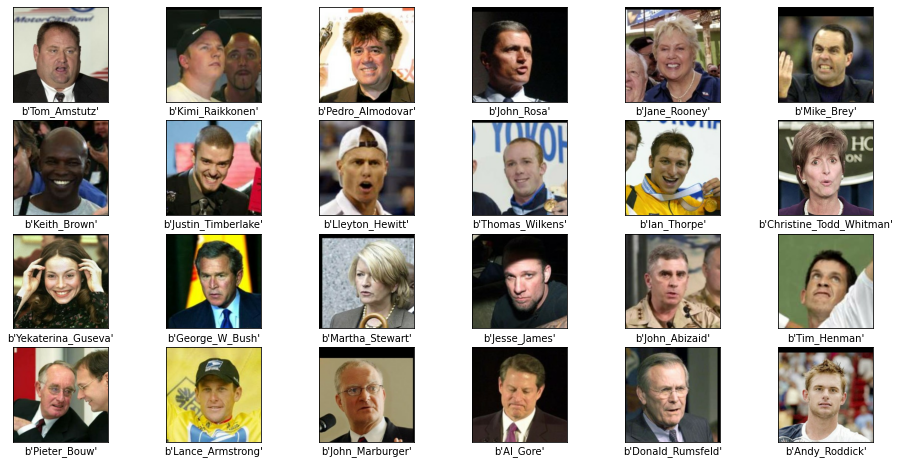

In [21]:
ds = train_ds.take(24)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

In [22]:
# Создаем пайплайны
INP_SIZE = 250
NUM_EPOCHS = 5
BATCH_SIZE = 64

def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=len(test_ds))
test_ds = test_ds.map(prepare)
test_ds = test_ds.repeat(NUM_EPOCHS)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
train_ds, test_ds

(<BatchDataset shapes: ((64, 250, 250, 3), (64,)), types: (tf.float32, tf.string)>,
 <BatchDataset shapes: ((64, 250, 250, 3), (64,)), types: (tf.float32, tf.string)>)

In [24]:
# CNN из урока
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [25]:
# Contrastive Loss
MARGIN = 10.00

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [26]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [27]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 95.61767578125
[200] Loss: 0.006121876183897257
[400] Loss: 0.43558359146118164
[600] Loss: 2.737886428833008
[800] Loss: 2.2625043392181396
CPU times: user 6min 55s, sys: 13.2 s, total: 7min 8s
Wall time: 8min 46s


In [28]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    # img = (1. - img).astype(np.float32)
    # img = np.mean(img, axis=2)
    # img = np.reshape(img, (INP_SIZE, INP_SIZE, 1))
    return img


In [29]:
bush_1 = load_and_prepare_image('bush.jpeg')
bush_2 = load_and_prepare_image('bush_2.jpg')
bieber = load_and_prepare_image('bieber.jpg')

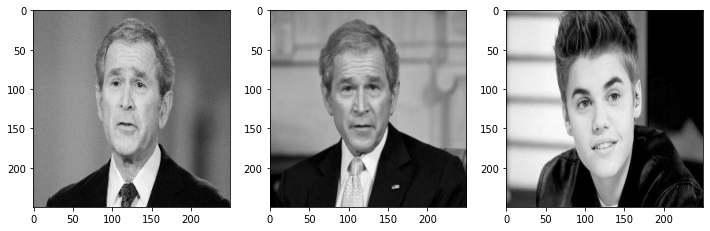

In [30]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(bush_1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(bush_2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(bieber[:,:,0], cmap='gray')
plt.show()

In [31]:
new_embs = model(np.stack((bush_1, bush_2, bieber), axis=0))

In [32]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('Bush_1 <-> Bush_2: ', diff(emb1, emb2))
print('Bush_2 <-> Bieber: ', diff(emb2, emb3))
print('Bush_1 <-> bieber: ', diff(emb1, emb3))

Bush_1 <-> Bush_2:  23.830809275035648
Bush_2 <-> Bieber:  35.34464452338395
Bush_1 <-> bieber:  26.513378293149007
